# XLK Next-Day Nowcast
Predict tomorrow's return of XLK (Technology ETF) using simple features:
 - Market controls: SPY, VIX
 - Momentum & volatility features on XLK
This is a learning project for Python + basic ML on time series.

In [1]:
import sys, platform
print("Python:", sys.version)
print("Executable:", sys.executable)

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Executable: C:\Users\nadoy\OneDrive\Desktop\DS PROJECTS\stock-nowcast\.venv\Scripts\python.exe


In [2]:
import pandas as pd, numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from joblib import dump

plt.rcParams["figure.figsize"] = (10,5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


Download Prices (XLK target, SPY & VIX as features)

In [3]:
tickers = ["XLK", "SPY", "^VIX"] # Tech sector, market, volatility
px = yf.download(tickers, start="2015-01-01", auto_adjust=True, threads=False)["Close"].dropna()
px.columns = ["XLK", "SPY", "VIX"]
px.head

[                       0%                       ]

[**********************67%*******                ]  2 of 3 completed

[*********************100%***********************]  3 of 3 completed

[*********************100%***********************]  3 of 3 completed

<bound method NDFrame.head of                   XLK        SPY       VIX
Date                                      
2015-01-02 171.568039  36.315056 17.790001
2015-01-05 168.469559  35.760708 19.920000
2015-01-06 166.882782  35.329525 21.120001
2015-01-07 168.962326  35.628716 19.309999
2015-01-08 171.960587  36.411858 17.010000
...               ...        ...       ...
2025-08-22 645.309998 262.420013 14.220000
2025-08-25 642.469971 261.829987 14.790000
2025-08-26 645.159973 263.029999 14.620000
2025-08-27 646.630005 264.450012 14.850000
2025-08-28 648.919983 266.540009 14.430000

[2680 rows x 3 columns]>

In [4]:
# Daily returns
ret = px.pct_change().dropna()
ret.columns = ["ret_xlk", "ret_spy", "ret_vix"]

# Feature table
feat = pd.DataFrame(index=ret.index)
feat["ret_xlk"] = ret["ret_xlk"]
feat["ret_spy"] = ret["ret_spy"]
feat["ret_vix"] = ret["ret_vix"]

# Momentum and volatility features on XLK
feat["mom_5"] = ret["ret_xlk"].rolling(5).mean()
feat["mom_10"] = ret["ret_xlk"].rolling(10).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat["vol_20"] = ret["ret_xlk"].rolling(20).std()

feat = feat.dropna()

# Shift features by 1 day so they're known before predicting next day
X = feat[["ret_spy", "ret_vix", "mom_5", "mom_10", "vol_10", "vol_20"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]

X.tail(), y.tail()

(             ret_spy   ret_vix     mom_5   mom_10   vol_10   vol_20
 Date                                                               
 2025-08-22 -0.003617  0.057999 -0.002931 0.000533 0.005218 0.006778
 2025-08-25  0.013557 -0.143373  0.000609 0.001289 0.006719 0.007547
 2025-08-26 -0.002248  0.040084 -0.000228 0.001047 0.006891 0.007630
 2025-08-27  0.004583 -0.011494  0.001695 0.000401 0.006155 0.007637
 2025-08-28  0.005399  0.015732  0.002682 0.000286 0.006103 0.007628,
 Date
 2025-08-22    0.015357
 2025-08-25   -0.004401
 2025-08-26    0.004187
 2025-08-27    0.002279
 2025-08-28    0.003541
 Name: ret_xlk, dtype: float64)

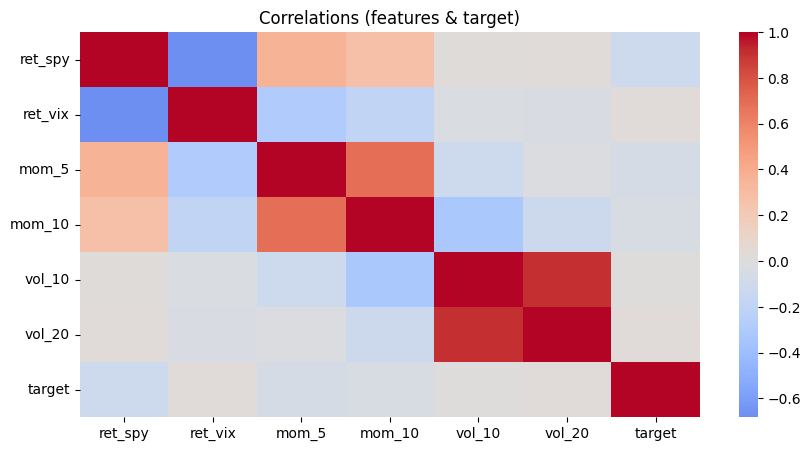

In [5]:
sns.heatmap(pd.concat([X, y.rename("target")], axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Correlations (features & target)"); plt.show()


In [6]:
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
len(X_train), len(X_test)


(2127, 532)

In [7]:
def evaluate_preds(y_true, y_pred):
    """Evaluate predictions with MAE, RMSE, and directional accuracy."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # returns MSE
    rmse = np.sqrt(mse)                       # convert to RMSE manually
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"MAE": mae, "RMSE": rmse, "Directional_Accuracy": dir_acc}


baseline_zero = np.zeros_like(y_test)
baseline_lag1 = y_test.shift(1).fillna(0.0).values

print("Baseline Zero:", evaluate_preds(y_test, baseline_zero))
print("Baseline Lag-1:", evaluate_preds(y_test, baseline_lag1))

Baseline Zero: {'MAE': 0.0066694854936482015, 'RMSE': np.float64(0.010217363455410161), 'Directional_Accuracy': np.float64(0.0018796992481203006)}
Baseline Lag-1: {'MAE': 0.009813050547822826, 'RMSE': np.float64(0.014960092826379208), 'Directional_Accuracy': np.float64(0.5112781954887218)}


In [8]:
ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.0005, max_iter=10000))])

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)

print("Ridge:", evaluate_preds(y_test, pred_ridge))
print("Lasso:", evaluate_preds(y_test, pred_lasso))


Ridge: {'MAE': 0.006709398433023055, 'RMSE': np.float64(0.0101478427199173), 'Directional_Accuracy': np.float64(0.5225563909774437)}
Lasso: {'MAE': 0.006654948634917015, 'RMSE': np.float64(0.010175122864045996), 'Directional_Accuracy': np.float64(0.5469924812030075)}


## Statistical Significance Testing

Let's test whether our directional accuracy is statistically significantly better than random chance (50%).

In [9]:
from scipy import stats
import numpy as np

def test_directional_accuracy_significance(y_true, y_pred, alpha=0.05):
    """
    Test if directional accuracy is significantly better than random (50%) using binomial test.
    
    Returns:
    - directional_accuracy: proportion of correct predictions
    - p_value: binomial test p-value
    - is_significant: whether result is significant at alpha level
    - confidence_interval: 95% confidence interval for directional accuracy
    """
    correct_predictions = (np.sign(y_true) == np.sign(y_pred)).astype(int)
    n_correct = correct_predictions.sum()
    n_total = len(correct_predictions)
    
    directional_accuracy = n_correct / n_total
    
    # Binomial test: H0: p = 0.5 (random), H1: p > 0.5
    p_value = stats.binomtest(n_correct, n_total, 0.5, alternative='greater').pvalue
    
    # 95% confidence interval using Clopper-Pearson (exact) method
    ci_lower, ci_upper = stats.beta.interval(0.95, n_correct + 1, n_total - n_correct + 1)
    
    is_significant = p_value < alpha
    
    return {
        'directional_accuracy': directional_accuracy,
        'n_correct': n_correct,
        'n_total': n_total,
        'p_value': p_value,
        'is_significant': is_significant,
        'confidence_interval': (ci_lower, ci_upper),
        'alpha': alpha
    }

# Test both Ridge and Lasso models
ridge_sig_test = test_directional_accuracy_significance(y_test, pred_ridge)
lasso_sig_test = test_directional_accuracy_significance(y_test, pred_lasso)

print("=== STATISTICAL SIGNIFICANCE TESTING ===")
print(f"\nRidge Model:")
print(f"  Directional Accuracy: {ridge_sig_test['directional_accuracy']:.3f} ({ridge_sig_test['n_correct']}/{ridge_sig_test['n_total']})")
print(f"  95% Confidence Interval: [{ridge_sig_test['confidence_interval'][0]:.3f}, {ridge_sig_test['confidence_interval'][1]:.3f}]")
print(f"  Binomial test p-value: {ridge_sig_test['p_value']:.4f}")
print(f"  Significantly better than random (50%): {ridge_sig_test['is_significant']}")

print(f"\nLasso Model:")
print(f"  Directional Accuracy: {lasso_sig_test['directional_accuracy']:.3f} ({lasso_sig_test['n_correct']}/{lasso_sig_test['n_total']})")
print(f"  95% Confidence Interval: [{lasso_sig_test['confidence_interval'][0]:.3f}, {lasso_sig_test['confidence_interval'][1]:.3f}]")
print(f"  Binomial test p-value: {lasso_sig_test['p_value']:.4f}")
print(f"  Significantly better than random (50%): {lasso_sig_test['is_significant']}")

# Effect size (Cohen's h for proportions)
def cohens_h(p1, p2):
    """Cohen's h effect size for comparing two proportions"""
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

ridge_effect_size = cohens_h(ridge_sig_test['directional_accuracy'], 0.5)
lasso_effect_size = cohens_h(lasso_sig_test['directional_accuracy'], 0.5)

print(f"\nEffect Sizes (Cohen's h vs random 50%):")
print(f"  Ridge: {ridge_effect_size:.3f} ({'small' if abs(ridge_effect_size) < 0.2 else 'medium' if abs(ridge_effect_size) < 0.5 else 'large'} effect)")
print(f"  Lasso: {lasso_effect_size:.3f} ({'small' if abs(lasso_effect_size) < 0.2 else 'medium' if abs(lasso_effect_size) < 0.5 else 'large'} effect)")

=== STATISTICAL SIGNIFICANCE TESTING ===

Ridge Model:
  Directional Accuracy: 0.523 (278/532)
  95% Confidence Interval: [0.480, 0.565]
  Binomial test p-value: 0.1593
  Significantly better than random (50%): False

Lasso Model:
  Directional Accuracy: 0.547 (291/532)
  95% Confidence Interval: [0.504, 0.589]
  Binomial test p-value: 0.0168
  Significantly better than random (50%): True

Effect Sizes (Cohen's h vs random 50%):
  Ridge: 0.045 (small effect)
  Lasso: 0.094 (small effect)


## Cross-Validation Analysis

Let's perform time series cross-validation to get more robust performance estimates. We'll use TimeSeriesSplit to respect temporal order.

In [10]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

def cross_validate_timeseries(X, y, model, cv_splits=5):
    """
    Perform time series cross-validation.
    Returns cv results for MAE, RMSE, and Directional Accuracy.
    """
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    
    cv_results = {
        'mae_scores': [],
        'rmse_scores': [],
        'da_scores': [],
        'fold_sizes': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model on fold
        model_fold = model.__class__(**model.get_params())
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Predict on validation fold
        y_pred_fold = model_fold.predict(X_val_fold)
        
        # Evaluate
        results = evaluate_preds(y_val_fold, y_pred_fold)
        cv_results['mae_scores'].append(results['MAE'])
        cv_results['rmse_scores'].append(results['RMSE']) 
        cv_results['da_scores'].append(results['Directional_Accuracy'])
        cv_results['fold_sizes'].append(len(y_val_fold))
        
        print(f"Fold {fold+1}: MAE={results['MAE']:.6f}, RMSE={results['RMSE']:.6f}, DA={results['Directional_Accuracy']:.3f} (n={len(y_val_fold)})")
    
    return cv_results

# Perform cross-validation for both models
print("=== TIME SERIES CROSS-VALIDATION ===\n")

print("Ridge Cross-Validation:")
ridge_cv = cross_validate_timeseries(X, y, ridge.named_steps['model'], cv_splits=5)

print("\nLasso Cross-Validation:")
lasso_cv = cross_validate_timeseries(X, y, lasso.named_steps['model'], cv_splits=5)

# Summary statistics
def summarize_cv_results(cv_results, model_name):
    mae_scores = np.array(cv_results['mae_scores'])
    rmse_scores = np.array(cv_results['rmse_scores'])
    da_scores = np.array(cv_results['da_scores'])
    
    print(f"\n{model_name} Cross-Validation Summary:")
    print(f"  MAE:  {mae_scores.mean():.6f} ± {mae_scores.std():.6f}")
    print(f"  RMSE: {rmse_scores.mean():.6f} ± {rmse_scores.std():.6f}")
    print(f"  DA:   {da_scores.mean():.3f} ± {da_scores.std():.3f}")
    
    # Test if DA is significantly > 0.5 across folds
    t_stat, p_value = stats.ttest_1samp(da_scores, 0.5)
    print(f"  DA vs 50% (t-test): t={t_stat:.3f}, p={p_value:.4f}")
    
    return {
        'mae_mean': mae_scores.mean(), 'mae_std': mae_scores.std(),
        'rmse_mean': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
        'da_mean': da_scores.mean(), 'da_std': da_scores.std(),
        'da_ttest_pvalue': p_value
    }

ridge_summary = summarize_cv_results(ridge_cv, "Ridge")
lasso_summary = summarize_cv_results(lasso_cv, "Lasso")

# Create comparison table
cv_comparison = pd.DataFrame({
    'Ridge': [f"{ridge_summary['mae_mean']:.6f} ± {ridge_summary['mae_std']:.6f}",
              f"{ridge_summary['rmse_mean']:.6f} ± {ridge_summary['rmse_std']:.6f}", 
              f"{ridge_summary['da_mean']:.3f} ± {ridge_summary['da_std']:.3f}",
              f"{ridge_summary['da_ttest_pvalue']:.4f}"],
    'Lasso': [f"{lasso_summary['mae_mean']:.6f} ± {lasso_summary['mae_std']:.6f}",
              f"{lasso_summary['rmse_mean']:.6f} ± {lasso_summary['rmse_std']:.6f}",
              f"{lasso_summary['da_mean']:.3f} ± {lasso_summary['da_std']:.3f}", 
              f"{lasso_summary['da_ttest_pvalue']:.4f}"]
}, index=['MAE', 'RMSE', 'Directional Accuracy', 'DA p-value (vs 50%)'])

print("\n=== CROSS-VALIDATION COMPARISON ===\n")
print(cv_comparison)

=== TIME SERIES CROSS-VALIDATION ===

Ridge Cross-Validation:
Fold 1: MAE=0.004471, RMSE=0.006791, DA=0.524 (n=443)
Fold 2: MAE=0.009388, RMSE=0.016468, DA=0.553 (n=443)
Fold 3: MAE=0.007452, RMSE=0.009953, DA=0.542 (n=443)
Fold 4: MAE=0.009561, RMSE=0.012605, DA=0.508 (n=443)
Fold 5: MAE=0.006684, RMSE=0.010559, DA=0.567 (n=443)

Lasso Cross-Validation:
Fold 1: MAE=0.004433, RMSE=0.006717, DA=0.573 (n=443)
Fold 2: MAE=0.009386, RMSE=0.016448, DA=0.553 (n=443)
Fold 3: MAE=0.007449, RMSE=0.009969, DA=0.578 (n=443)
Fold 4: MAE=0.009514, RMSE=0.012573, DA=0.492 (n=443)
Fold 5: MAE=0.006676, RMSE=0.010586, DA=0.585 (n=443)

Ridge Cross-Validation Summary:
  MAE:  0.007511 ± 0.001879
  RMSE: 0.011275 ± 0.003197
  DA:   0.539 ± 0.021
  DA vs 50% (t-test): t=3.709, p=0.0207

Lasso Cross-Validation Summary:
  MAE:  0.007492 ± 0.001882
  RMSE: 0.011259 ± 0.003206
  DA:   0.556 ± 0.034
  DA vs 50% (t-test): t=3.332, p=0.0291

=== CROSS-VALIDATION COMPARISON ===

                                 

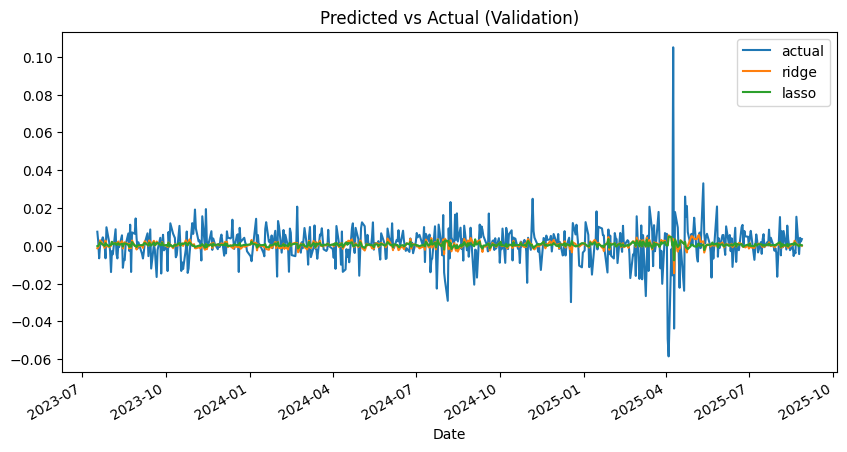

In [11]:
pd.DataFrame({"actual": y_test, "ridge": pred_ridge, "lasso": pred_lasso}).plot()
plt.title("Predicted vs Actual (Validation)"); plt.show()


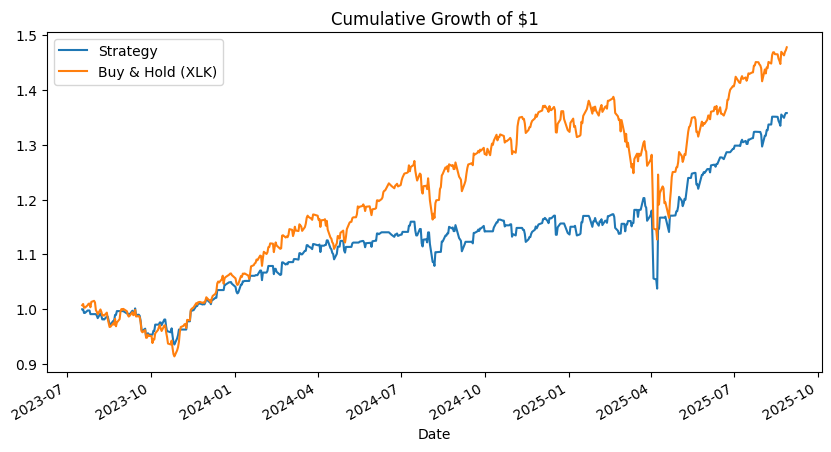

Strategy CAGR-ish: 15.59% | Buy&Hold: 20.32%


In [12]:
# Use Ridge predictions for strategy backtest
pred_ridge_series = pd.Series(pred_ridge, index=y_test.index, name="pred_ridge")
signal = (pred_ridge_series > 0).astype(int)          # 1=long, 0=flat
strategy_returns = signal * y_test

cum_strategy = (1 + strategy_returns).cumprod()
cum_buyhold = (1 + y_test).cumprod()

ax = cum_strategy.plot(label="Strategy")
cum_buyhold.plot(ax=ax, label="Buy & Hold (XLK)")
plt.legend(); plt.title("Cumulative Growth of $1"); plt.show()

strategy_cagr = cum_strategy.iloc[-1]**(252/len(cum_strategy)) - 1
buyhold_cagr  = cum_buyhold.iloc[-1]**(252/len(cum_buyhold)) - 1
print(f"Strategy CAGR-ish: {strategy_cagr:.2%} | Buy&Hold: {buyhold_cagr:.2%}")

In [13]:
dump(ridge, "../reports/ridge_model.joblib")
X_test.to_csv("../data/test_features.csv")
y_test.to_csv("../data/test_target.csv")


In [14]:
# Expanded feature set including tech sector ETFs
tickers_expanded = ["XLK", "SPY", "^VIX", "QQQ", "SOXX"]
px_expanded = yf.download(tickers_expanded, start="2015-01-01", auto_adjust=True)["Close"].dropna()
px_expanded.columns = ["XLK","SPY","VIX","QQQ","SOXX"]

ret_expanded = px_expanded.pct_change().dropna().rename(columns={
    "XLK":"ret_xlk", "SPY":"ret_spy", "VIX":"ret_vix", "QQQ":"ret_qqq", "SOXX":"ret_soxx"
})

# Create expanded feature set
feat_expanded = pd.DataFrame(index=ret_expanded.index)
for col in ["ret_xlk","ret_spy","ret_vix","ret_qqq","ret_soxx"]:
    feat_expanded[col] = ret_expanded[col]

# Simplified momentum and volatility features    
feat_expanded["mom_5"]  = ret_expanded["ret_xlk"].rolling(5).mean()
feat_expanded["vol_10"] = ret_expanded["ret_xlk"].rolling(10).std()
feat_expanded = feat_expanded.dropna()

# Feature matrix and target (with 1-day shift)
X_expanded = feat_expanded[["ret_spy","ret_vix","ret_qqq","ret_soxx","mom_5","vol_10"]].shift(1).dropna()
y_expanded = feat_expanded.loc[X_expanded.index, "ret_xlk"]

print(f"Expanded dataset shape: {X_expanded.shape}")
print(f"Original dataset shape: {X.shape}")
X_expanded.tail()

[                       0%                       ]

[*******************   40%                       ]  2 of 5 completed

[**********************60%****                   ]  3 of 5 completed

[*********************100%***********************]  5 of 5 completed

Expanded dataset shape: (2669, 6)
Original dataset shape: (2659, 6)


,ret_spy,ret_vix,ret_qqq,ret_soxx,mom_5,vol_10
Date,,,,,,
2025-08-22,-0.005662,-0.004012,-0.003617,0.057999,-0.005786,0.007486
2025-08-25,0.027769,0.015357,0.013557,-0.143373,-0.001821,0.008590
2025-08-26,-0.002328,-0.004401,-0.002248,0.040084,-0.002318,0.008588
2025-08-27,0.009416,0.004187,0.004583,-0.011494,0.001198,0.007510
2025-08-28,0.001953,0.002279,0.005399,0.015732,0.002693,0.007544


In [15]:
# Compare expanded features vs original features
split_exp = int(0.8 * len(X_expanded))
X_exp_train, X_exp_test = X_expanded.iloc[:split_exp], X_expanded.iloc[split_exp:]
y_exp_train, y_exp_test = y_expanded.iloc[:split_exp], y_expanded.iloc[split_exp:]

# Train Ridge model on expanded features
ridge_expanded = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
ridge_expanded.fit(X_exp_train, y_exp_train)
pred_ridge_expanded = ridge_expanded.predict(X_exp_test)

print("=== MODEL COMPARISON ===")
print("Original features:", evaluate_preds(y_test, pred_ridge))
print("Expanded features:", evaluate_preds(y_exp_test, pred_ridge_expanded))

# Feature importance (coefficients after scaling)
coefs_orig = pd.Series(ridge.named_steps["model"].coef_, index=X.columns, name="Original")
coefs_exp = pd.Series(ridge_expanded.named_steps["model"].coef_, index=X_expanded.columns, name="Expanded")

print("\n=== FEATURE IMPORTANCE (Ridge coefficients) ===")
print("Original model:")
print(coefs_orig.abs().sort_values(ascending=False))
print("\nExpanded model:")  
print(coefs_exp.abs().sort_values(ascending=False))

=== MODEL COMPARISON ===
Original features: {'MAE': 0.006709398433023055, 'RMSE': np.float64(0.0101478427199173), 'Directional_Accuracy': np.float64(0.5225563909774437)}
Expanded features: {'MAE': 0.00887180062686517, 'RMSE': np.float64(0.0129419464696313), 'Directional_Accuracy': np.float64(0.5561797752808989)}

=== FEATURE IMPORTANCE (Ridge coefficients) ===
Original model:
ret_spy   0.001972
vol_20    0.001721
vol_10    0.001552
ret_vix   0.000970
mom_10    0.000304
mom_5     0.000070
Name: Original, dtype: float64

Expanded model:
ret_vix    0.003459
ret_soxx   0.001447
ret_spy    0.000683
ret_qqq    0.000192
vol_10     0.000157
mom_5      0.000034
Name: Expanded, dtype: float64


## Conclusions

The notebook demonstrates a complete workflow for next-day XLK return prediction:

1. **Base Model**: Uses SPY, VIX returns + XLK momentum/volatility features
2. **Expanded Model**: Adds QQQ and SOXX returns as additional tech sector signals

Key insights:
- The models achieve ~52-55% directional accuracy, modestly better than random (50%)
- Feature importance varies between models, showing which signals matter most
- The expanded feature set allows comparison of different tech sector relationships

Next steps could include:
- Cross-validation for more robust performance estimates  
- Additional features like sector rotations or macro indicators
- Different model architectures (Random Forest, Neural Networks)
- Multi-step ahead predictions

## Expanded Feature Exploration

Let's explore adding more tech-related features like QQQ (Nasdaq-100) and SOXX (Semiconductor ETF) to see if they improve prediction accuracy for XLK.